In [61]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_df, RESPONSE_ERROR
from src.analysis import get_sanity_check, add_classification_scores, get_macro_accuracies, add_llm_info
from src.plot import plot_accuracies
from src.llms import LLM, LLMGroup
import seaborn as sns
import pandas as pd

sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fallacy Classification Analysis

## Experiment 4: Fallacy Classification with zero-shot Prompt

In [62]:
df_fallacies_e4 = get_fallacy_df('data/fallacies_e4.csv')

# GPT-4 responses are incomplete and API usage is too expensive to get all responses.
# We use about 2300 input tokens per classification prompt, which means 5.336M tokens for 2320 samples.
# For classification with GPT-4 alone, the total cost would be $160.

# I also ran 135 classification prompts with o1-preview-2024-09-12. For each prompt, 2048 of about 2300 input tokens were cached,
# but the overall cost would still be way too high.

# https://openai.com/api/pricing/
# gpt-4:                    $30.00 / 1M tokens
# gpt-4o-mini-2024-07-18:   $0.150 / 1M input tokens
# gpt-4o-2024-08-06:        $2.50 / 1M input tokens
# o1-preview-2024-09-12:    $15.00 / 1M input tokens () 

df_fallacies_e4.drop(columns=['gpt_4_response', 'o1_preview_response'], inplace=True)

df_fallacies_e4.head()

[2024-11-01 13:09:56] Loaded existing fallacy dataframe from data/fallacies_e4.csv.


,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4o_mini_response,claude_3_5_sonnet_response,claude_3_haiku_response,gemini_1_5_pro_response,gemini_1_5_flash_8b_response,mistral_large_2_response,mistral_small_2_response,llama_3_1_70b_response,llama_3_1_8b_response
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Denying the Antecedent,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence.
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,Argument from Silence,Affirming the Consequent,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,(164) Argument from Silence,Argument from Silence,Argument from Silence.
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Appeal to Silence,Argument from Silence,Argument from Silence.
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,Argument from Silence,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority,Appeal to Authority,Argument from Silence,Appeal to Authority,Argument from Silence,Argument from False Authority.
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence,Argument from Silence.


### Scoring and Sanity Check

In [63]:
add_classification_scores(df_fallacies_e4)

# Check completeness of responses, predictions and scores
df_fallacies_e4.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   step                          2320 non-null   object
 1   entity                        2320 non-null   object
 2   fallacy                       2320 non-null   object
 3   label                         2320 non-null   UInt8 
 4   category                      2320 non-null   object
 5   subcategory                   2320 non-null   object
 6   gpt_4o_response               2320 non-null   object
 7   gpt_4o_mini_response          2320 non-null   object
 8   claude_3_5_sonnet_response    2320 non-null   object
 9   claude_3_haiku_response       2320 non-null   object
 10  gemini_1_5_pro_response       2319 non-null   object
 11  gemini_1_5_flash_8b_response  2320 non-null   object
 12  mistral_large_2_response      2320 non-null   object
 13  mistral_small_2_re

In [64]:
get_sanity_check(df_fallacies_e4)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o,20.5,0,72
gpt_4o_mini,20.9,0,47
claude_3_5_sonnet,20.8,0,68
claude_3_haiku,48.4,0,156
gemini_1_5_pro,19.8,1,47
gemini_1_5_flash_8b,20.6,0,254
mistral_large_2,21.9,0,56
mistral_small_2,23.5,0,123
llama_3_1_70b,29.4,2,60
llama_3_1_8b,28.6,0,24


### Global Accuracies

In [65]:
_, df_subcategory_accuracies_e4, df_category_accuracies_e4, df_global_accuracies_e4 = get_macro_accuracies(df_fallacies_e4)

In [66]:
df_global_accuracies_e4 = df_global_accuracies_e4.sort_values('accuracy', ascending=False)
df_global_accuracies_e4.round(1)

,accuracy
gpt_4o,47.3
claude_3_5_sonnet,42.1
gemini_1_5_pro,41.5
llama_3_1_70b,28.4
mistral_large_2,25.8
gpt_4o_mini,24.2
gemini_1_5_flash_8b,18.8
claude_3_haiku,15.8
mistral_small_2,14.4
llama_3_1_8b,11.0


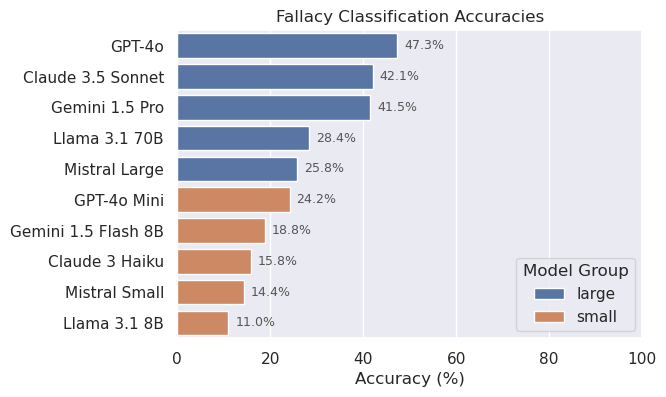

In [67]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e4),
    figsize=(6, 4),
    title='Fallacy Classification Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

- GPT-4o achieves best classification accuracy of 47.3%, even better than 35% achieved by GPT-4 (Hong et al., 2024).
- Lightweight LLMs perform worse, but still much better than the models tested by Hong et al. (2024).

### Fallacy Category Accuracies

In [68]:
df_category_accuracies_e4.round(1)

category,formal,informal
gpt_4o,52.8,41.7
gpt_4o_mini,33.1,15.2
claude_3_5_sonnet,46.7,37.4
claude_3_haiku,16.0,15.5
gemini_1_5_pro,44.8,38.2
gemini_1_5_flash_8b,25.9,11.7
llama_3_1_70b,33.3,23.5
llama_3_1_8b,16.4,5.7
mistral_large_2,29.8,21.8
mistral_small_2,19.6,9.1


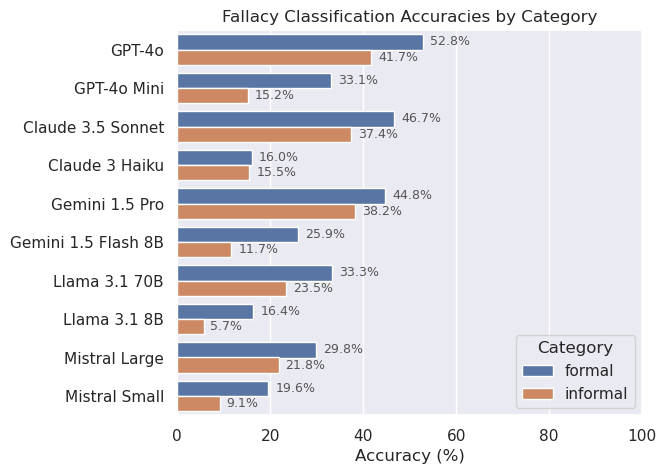

In [69]:
df_category_accuracies_long_e4 = pd.melt(df_category_accuracies_e4, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e4),
    figsize=(6, 5),
    title='Fallacy Classification Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

In [70]:
df_plot = add_llm_info(df_category_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category']).mean()
df_plot.round(1)

accuracy
llm_group category          
large     formal        41.5
          informal      32.5
small     formal        22.2
          informal      11.4

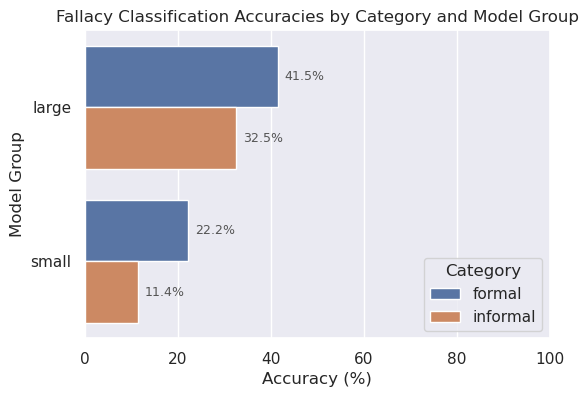

In [71]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Classification Accuracies by Category and Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    annotate=True,
)

- In contrast to fallacy identification, classification accuracies are higher for formal fallacies.
- Flagship LLMs outperform lightweight LLMs substantially.

### Fallacy Subcategory Accuracies

In [72]:
df_subcategory_accuracies_e4.round(1)

category                   formal                                             \
subcategory         probabilistic propositional quantificational syllogistic   
gpt_4o                       57.5          65.0             50.0        38.8   
gpt_4o_mini                  60.0          48.3              1.7        22.5   
claude_3_5_sonnet            37.5          75.0             26.7        47.5   
claude_3_haiku               20.0          36.7              0.0         7.5   
gemini_1_5_pro               67.5          55.0             31.7        25.0   
gemini_1_5_flash_8b          27.5          45.0             15.0        16.2   
llama_3_1_70b                62.5          55.0              3.3        12.5   
llama_3_1_8b                 30.0          26.7              0.0         8.8   
mistral_large_2              55.0          46.7              0.0        17.5   
mistral_small_2              37.5          30.0              3.3         7.5   

category             informal                                          \
subcategory         ambiguity inappropriate presumption inconsistency   
gpt_4o                   44.0                      39.8          46.7   
gpt_4o_mini              19.3                      11.3           3.3   
claude_3_5_sonnet        42.0                      28.1          40.0   
claude_3_haiku           15.3                      11.1          16.7   
gemini_1_5_pro           46.0                      30.7          40.0   
gemini_1_5_flash_8b      18.0                      15.6           0.0   
llama_3_1_70b            28.7                      16.7          16.7   
llama_3_1_8b              8.0                       3.7           0.0   
mistral_large_2          27.3                      19.6           6.7   
mistral_small_2           4.7                       7.4           3.3   

category                                       
subcategory         insufficiency irrelevance  
gpt_4o                       36.0        42.1  
gpt_4o_mini                  17.9        24.1  
claude_3_5_sonnet            33.4        43.6  
claude_3_haiku               16.9        17.7  
gemini_1_5_pro               33.6        40.6  
gemini_1_5_flash_8b          11.2        13.6  
llama_3_1_70b                28.6        26.8  
llama_3_1_8b                  6.4        10.3  
mistral_large_2              24.0        31.4  
mistral_small_2              12.6        17.7

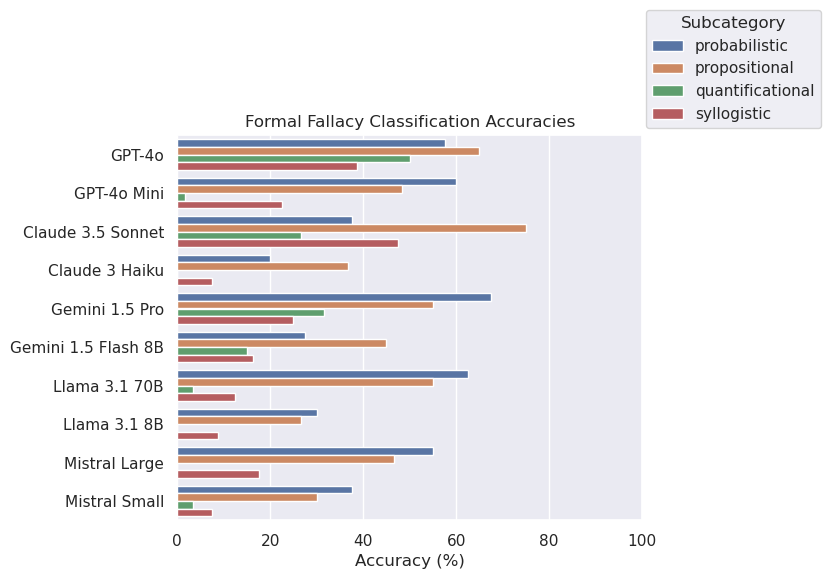

In [73]:
df_subcategory_accuracies_long_e4 = pd.melt(df_subcategory_accuracies_e4, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e4),
    figsize=(6, 5),
    title='Formal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=False,
)

In [74]:
df_plot = add_llm_info(df_formal_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot.round(1)

,llm_group,category,subcategory,accuracy
0,large,formal,probabilistic,56.0
1,large,formal,propositional,59.3
2,large,formal,quantificational,22.3
3,large,formal,syllogistic,28.2
4,small,formal,probabilistic,35.0
5,small,formal,propositional,37.3
6,small,formal,quantificational,4.0
7,small,formal,syllogistic,12.5


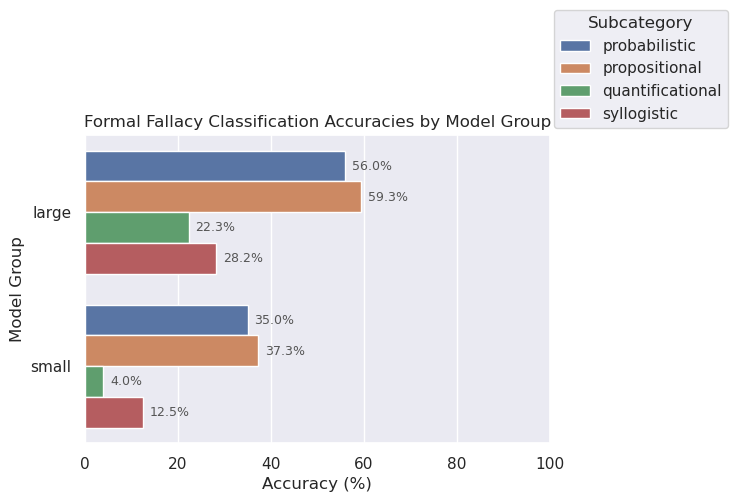

In [75]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Classification Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.4, 1),
    annotate=True,
)

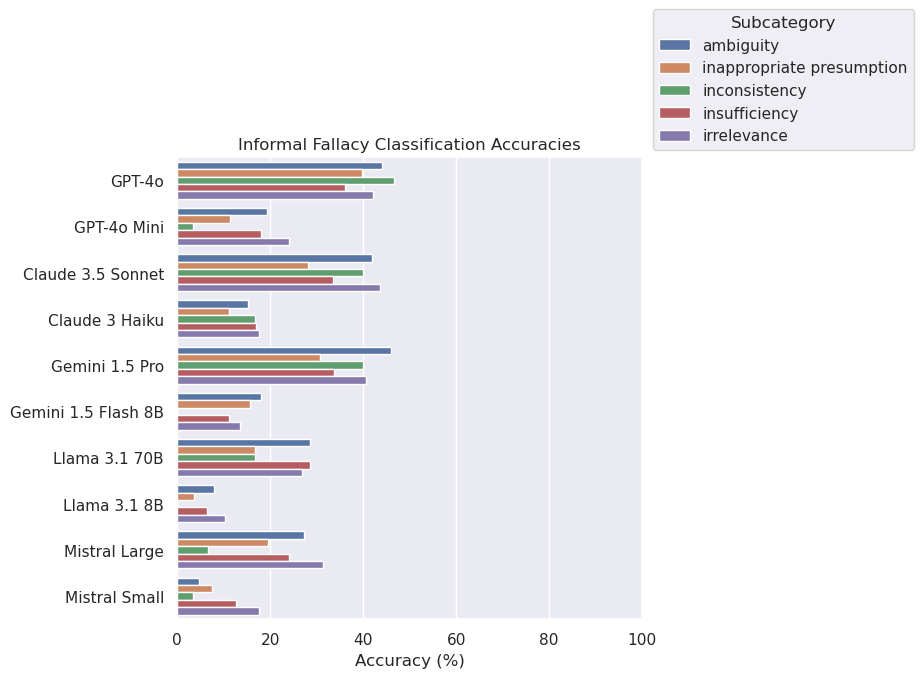

In [76]:
df_informal_accuracies_long_e4 = df_subcategory_accuracies_long_e4[
    df_subcategory_accuracies_long_e4['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e4),
    figsize=(6, 6),
    title='Informal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_anchor=(1.6, 1),
    annotate=False,
)

In [77]:
df_plot = add_llm_info(df_informal_accuracies_long_e4, group=True).groupby(
    ['llm_group', 'category', 'subcategory']).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,informal,ambiguity,37.6
1,large,informal,inappropriate presumption,27.0
2,large,informal,inconsistency,30.0
3,large,informal,insufficiency,31.137931
4,large,informal,irrelevance,36.897436
5,small,informal,ambiguity,13.066667
6,small,informal,inappropriate presumption,9.814815
7,small,informal,inconsistency,4.666667
8,small,informal,insufficiency,13.0
9,small,informal,irrelevance,16.666667


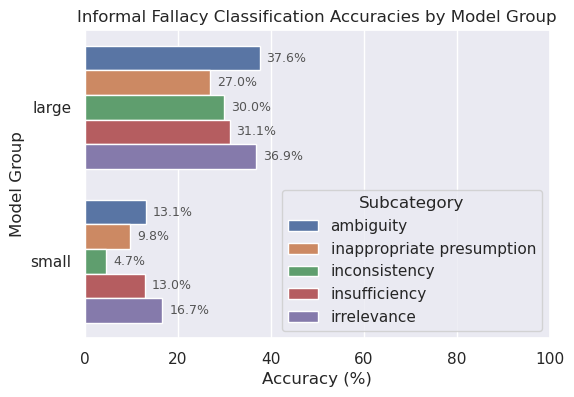

In [78]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Classification Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    annotate=True,
)

## Experiment 5: Fallacy Classification with Fine-Tuning

In [79]:
# Answers from classification (experiment 4) will be compared with fine-tuned models.
df_fallacies_e4 = get_fallacy_df('data/fallacies_e4.csv')
df_fallacies_e5 = get_fallacy_df('data/fallacies_e5.csv')

df_fallacies_e5 = df_fallacies_e5.merge(
    df_fallacies_e4[['entity', 'fallacy', 'gpt_4o_response', 'gpt_4o_mini_response']],
    on=['entity', 'fallacy']
)
df_fallacies_e5.head()

[2024-11-01 13:10:03] Loaded existing fallacy dataframe from data/fallacies_e4.csv.
[2024-11-01 13:10:03] Loaded existing fallacy dataframe from data/fallacies_e5.csv.


,step,entity,fallacy,label,category,subcategory,tuning,gpt_4o_mini_tuned_v1_response,gpt_4o_response,gpt_4o_mini_response
0,Since Tim asked John if he had seen his boonk ...,boonk,Argument from Silence,1,informal,insufficiency,test,Argument from Silence,Argument from Silence,Denying the Antecedent
1,Since I asked if wheelbirds can fly and you di...,wheelbirds,Argument from Silence,1,informal,insufficiency,test,Argument from Silence,Argument from Silence,Argument from Silence
2,Since Farmer Joe claims there are troughs in t...,troughs,Argument from Silence,1,informal,insufficiency,test,Argument from Silence,Argument from Silence,Argument from Silence
3,Since Electronics Engineer Ethan claims that o...,nanofarad,Argument from Silence,1,informal,insufficiency,test,Argument from Silence,Argument from Silence,Appeal to Silence
4,Since Megan accuses John of hiding the mamadin...,mamading,Argument from Silence,1,informal,insufficiency,test,Argument from Silence,Argument from Silence,Argument from Silence


### Scoring and Sanity Check

In [80]:
add_classification_scores(df_fallacies_e5)

# Check completeness of responses
df_fallacies_e5.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   step                           1160 non-null   object
 1   entity                         1160 non-null   object
 2   fallacy                        1160 non-null   object
 3   label                          1160 non-null   UInt8 
 4   category                       1160 non-null   object
 5   subcategory                    1160 non-null   object
 6   tuning                         1160 non-null   object
 7   gpt_4o_mini_tuned_v1_response  1160 non-null   object
 8   gpt_4o_response                1160 non-null   object
 9   gpt_4o_mini_response           1160 non-null   object
 10  gpt_4o_pred                    1121 non-null   object
 11  gpt_4o_score                   1160 non-null   UInt8 
 12  gpt_4o_mini_pred               1138 non-null   object
 13  gpt

In [81]:
get_sanity_check(df_fallacies_e5)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o_mini_tuned_v1,19.2,0,4
gpt_4o,20.3,0,39
gpt_4o_mini,20.8,0,22


### Global Accuracies

In [82]:
_, df_subcategory_accuracies_e5, df_category_accuracies_e5, df_global_accuracies_e5 = get_macro_accuracies(df_fallacies_e5)

In [83]:
df_global_accuracies_e5 = df_global_accuracies_e5.sort_values('accuracy', ascending=False)
df_global_accuracies_e5.round(1)

,accuracy
gpt_4o_mini_tuned_v1,78.1
gpt_4o,47.1
gpt_4o_mini,24.0


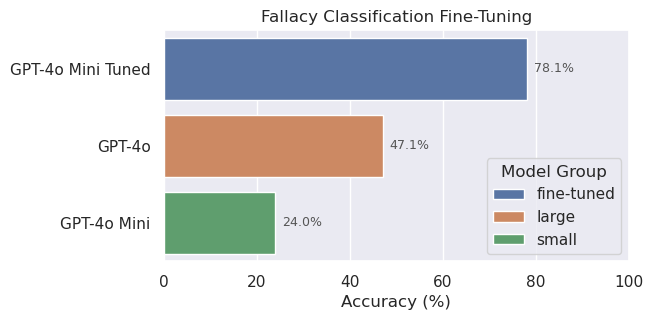

In [90]:
plot_accuracies(
    data=add_llm_info(df_global_accuracies_e5),
    figsize=(6, 3),
    title='Fallacy Classification Fine-Tuning',
    hue='llm_group',
    legend_title='Model Group',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_TUNED, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

- Fine-tuning leads to massive increases in classification accuracy.
- The fine-tuned GPT-4o Mini outperforms even the flagship GPT-4o model by a substantial amount.
- GPT-4o Mini accuracies differ slightly compared to experiment 4, because we only use the answers for the fine-tuning test set.

### Fallacy Category Accuracies

In [85]:
df_category_accuracies_e5

category,formal,informal
gpt_4o,54.375,39.850987
gpt_4o_mini,31.458333,16.446056
gpt_4o_mini_tuned_v1,92.5,63.685942


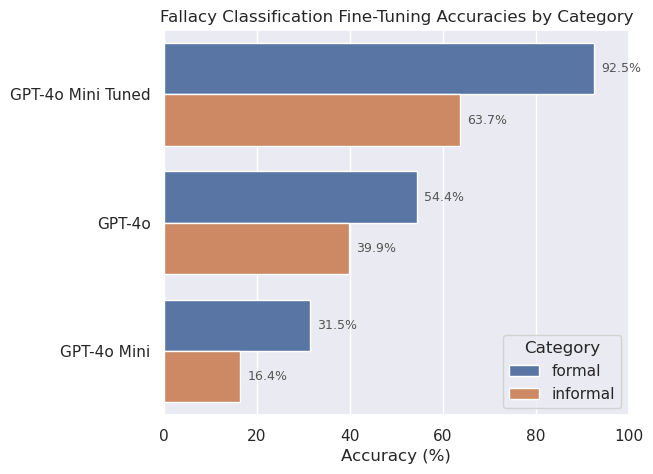

In [86]:
df_category_accuracies_long_e5 = pd.melt(df_category_accuracies_e5, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e5),
    figsize=(6, 5),
    title='Fallacy Classification Fine-Tuning Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_TUNED, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

- Fine-tuning increases classification accuracies both for formal and informal fallacies.
- Better classification accuracies for formal fallacies with and without fine-tuning.

### Fallacy Subcategory Accuracies

In [87]:
df_subcategory_accuracies_e5.round(1)

category                    formal                                             \
subcategory          probabilistic propositional quantificational syllogistic   
gpt_4o                        65.0          63.3             46.7        42.5   
gpt_4o_mini                   60.0          43.3              0.0        22.5   
gpt_4o_mini_tuned_v1         100.0          96.7             83.3        90.0   

category              informal                                          \
subcategory          ambiguity inappropriate presumption inconsistency   
gpt_4o                    44.0                      38.9          40.0   
gpt_4o_mini               21.3                      11.9           6.7   
gpt_4o_mini_tuned_v1      57.3                      73.3          40.0   

category                                        
subcategory          insufficiency irrelevance  
gpt_4o                        34.8        41.5  
gpt_4o_mini                   18.3        24.1  
gpt_4o_mini_tuned_v1          68.3        79.5

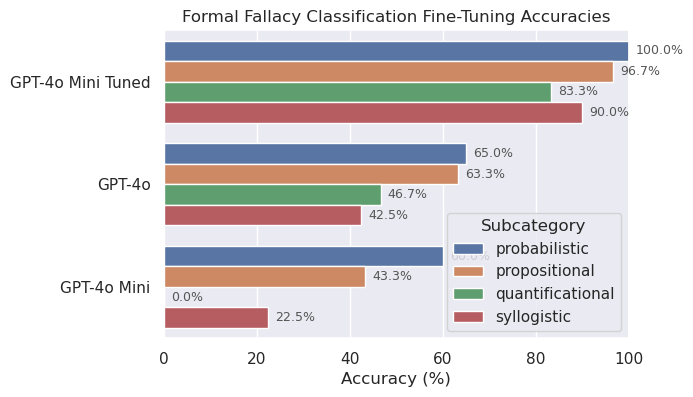

In [88]:
df_subcategory_accuracies_long_e5 = pd.melt(df_subcategory_accuracies_e5, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e5 = df_subcategory_accuracies_long_e5[
    df_subcategory_accuracies_long_e5['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e5),
    figsize=(6, 4),
    title='Formal Fallacy Classification Fine-Tuning Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_TUNED, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

- Fine-tuning seems to eliminate weaknesses for specific subcategories, e.g. for quantificational and syllogistic fallacies.

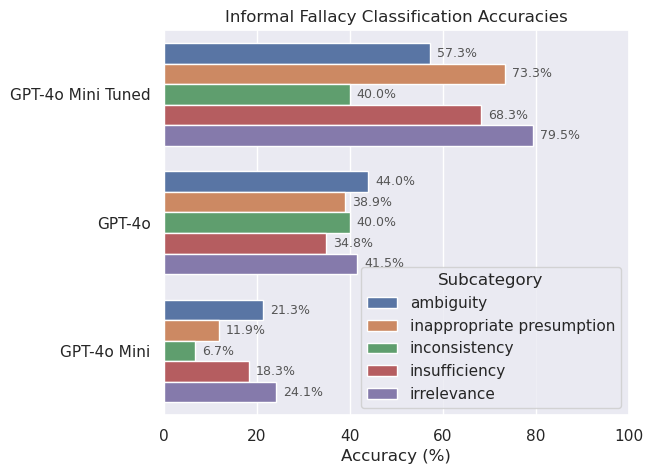

In [89]:
df_informal_accuracies_long_e5 = df_subcategory_accuracies_long_e5[
    df_subcategory_accuracies_long_e5['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e5),
    figsize=(6, 5),
    title='Informal Fallacy Classification Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_TUNED, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)